In [1]:
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale
import numpy as np
import scipy
from sklearn.metrics import (
    roc_auc_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

from briertools.scorers import DCAScorer, LogLossScorer, BrierScorer

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [2]:
log_loss_scorer = LogLossScorer()
dca_scorer = DCAScorer()
brier_scorer = BrierScorer()

## Set up helper functions
The `simulate_binormal` function does [TODO: explain what the hell this does]

In [3]:
def simulate_binormal(loc, scale=1, scale_neg=1, loc_neg=None, n=3000, fix=True):
    if loc_neg is None:
        loc_neg = -loc
    neg = np.random.normal(loc=loc_neg, scale=scale_neg, size=n)
    pos = np.random.normal(loc=loc, scale=scale, size=n)
    if fix:
        pos, neg = neg, pos
    y_pred = scipy.special.expit(np.concatenate([pos, neg]))
    y_true = np.concatenate([pos * 0 + 1, neg * 0])
    
    return y_pred, y_true

def scale_x_one_minus_one_minus_x_2(ax):
    def forward(x):
        return 1 - (1 - x)**2  # This is the actual transformation for labels
    def inverse(y):
        one_minus = 1 - y
        return 1 - np.sign(one_minus) * np.sqrt(np.abs(one_minus))
    ax.set_xscale(FuncScale(ax.xaxis, (forward, inverse)))
    ax.set_title("1-(1-x)^2")

## Toy Examples

### Sentencing Example
While Blackstone's maxim asserts the cost ratio of false negatives to false positives should be 10:1, Benjamin Franklin later advocated for a cost ratio of 100:1. 

Let's compare two sentencing classifiers across a range of relevant cost ratios.
The shaded area will represent the practical range of cost ratios discussed in the article.

While the blue classifier achieves higher accuracy under traditional 1:1 cost assumptions, the orange classifier demonstrates superior performance across the practically relevant range of cost ratios (5:1 to 100:1).

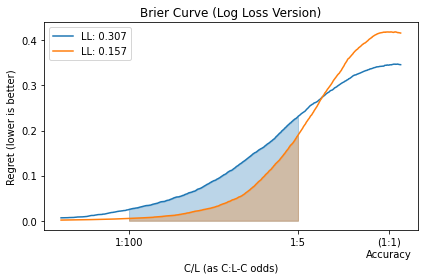

In [4]:
y_pred, y_true = simulate_binormal(1, 2, scale_neg=2)
log_loss_scorer.plot_curve(       
        y_true,
        y_pred,
        threshold_range=(0.003, 0.55),
        fill_range=(1.0 / 101, 1.0 / 6),
        ticks=[1.0 / 101, 1.0 / 6, 1.0 / 2],
)
y_pred, y_true = simulate_binormal(1, 1)
log_loss_scorer.plot_curve(
        y_true,
        y_pred,
        threshold_range=(0.003, 0.55),
        fill_range=(1.0 / 101, 1.0 / 6),
        ticks=[1.0 / 101, 1.0 / 6, 1.0 / 2],
)

### Fraud Example

In [ ]:
y_pred, y_true = simulate_binormal(1, 1.5)
log_loss_scorer.plot_curve(
        y_true,
        y_pred,
        threshold_range=(0.333, 0.995),
        fill_range=(0.925, 0.983),
        ticks=[1.0 / 2, 10.0 / 11, 100.0 / 101],
)

y_pred, y_true = simulate_binormal(1, 5)
log_loss_scorer.plot_curve(
        y_true,
        y_pred,
        threshold_range=(0.333, 0.995),
        fill_range=(0.925, 0.983),
        ticks=[1.0 / 2, 10.0 / 11, 100.0 / 101],
)

### Cancer Example

In [ ]:
y_pred, y_true = simulate_binormal(1, 1, scale_neg=8)
log_loss_scorer.plot_curve(
    y_true,
    y_pred,
    threshold_range=(0.03, 0.66),
    fill_range=(1.0 / 11, 1.0 / 3),
    ticks=[1.0 / 11, 1.0 / 3, 1.0 / 2],
)

y_pred, y_true = simulate_binormal(1, 1)
log_loss_scorer.plot_curve(
    y_true,
    y_pred,
    threshold_range=(0.03, 0.66),
    fill_range=(1.0 / 11, 1.0 / 3),
    ticks=[1.0 / 11, 1.0 / 3, 1.0 / 2],
)

## Comparing classifiers with respect to ranking & calibration
The orange classifier in the vignette below has good ranking and poor calibration. The blue classifier has slightly worse ranking but is much better calibrated. 

Depending on the metrics we use to visually compare classifier performance, we may make very different choices.

Using AUC-ROC (as in the left subplot), we would choose the orange classifier. However, if we looked at the expectation of regret over all possible accuracies (i.e. the center plot with log loss), we would choose the blue classifier. The plot (right subplot) decomposing the expected regret into discrimination and calibration losses explains why this is the case.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

titles = [
    "AUC-ROC",
    "Log Loss",
    "Log Loss Decomposition",
]
xlabels = [
    "False Positive Rate",
    "Accuracy",
    "Calibration Loss",
]
ylabels = [
    "True Positive Rate",
    "Regret (lower is better)",
    "Discrimination Loss",
]

y_pred_a, y_true_a = simulate_binormal(0.8, 1, fix=False, n=300)
y_pred_b, y_true_b = simulate_binormal(3, 0.5, loc_neg=1, fix=False, n=300)

for y_pred, y_true, clf_name in [(y_pred_a, y_true_a, 'A'), (y_pred_b, y_true_b, 'B')]:
    plt.sca(axs[0])
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label=f"AUC: {auc:.2f}")
    
    plt.sca(axs[1])
    log_loss_scorer.plot_curve(y_true, y_pred, ticks=[1.0 / 101, 1.0 / 2])
    
    plt.sca(axs[2])
    calibration_loss, discrimination_loss = log_loss_scorer._partition_loss(y_true, y_pred, log_loss_scorer.score)
    # print(calibration_loss, discrimination_loss)
    plt.scatter(calibration_loss, discrimination_loss, s=100)
    plt.xlim([0, 0.6])
    plt.ylim([0, 0.6])
    
for i in range(len(axs)):
    axs[i].set_title(titles[i])
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_ylabel(ylabels[i])
    if len(axs[i].artists) > 0:
        axs[i].legend()

plt.tight_layout()
plt.text(-1.0, 0.7, "Comparing AUC-ROC, Log Loss, and Decomposition Plots", size=50)

## Decision Curve Analysis with Rescaling

In [ ]:
y_hat_0, y_0 = simulate_binormal(0.8, 1, fix=False, n=300)
y_hat_1, y_1 = simulate_binormal(3, 0.5, loc_neg=1, fix=False, n=300)

fig, axs = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
axs[2].set_xscale("log")
scale_x_one_minus_one_minus_x_2(axs[1])

for ax in axs:
    plt.sca(ax)
    dca_scorer.plot_curve(
        y_1,
        y_hat_1,
        ticks=[1.0 / 101, 1.0 / 2],
        threshold_range=[1e-2, 1 - 1e-2],
        fill_range=0.15 if ax != axs[0] else None,
    )
    dca_scorer.plot_curve(
        y_0,
        y_hat_0,
        ticks=[1.0 / 101, 1.0 / 2],
        threshold_range=[1e-2, 1 - 1e-2],
        fill_range=0.4 if ax != axs[0] else None,
    )
    if ax != axs[0]:
        plt.axhline(y=0.5, color="black", linestyle="--", lw=0.5, zorder=-10)

xtick_labels = [
    r"$\frac{1}{10}$ $\frac{1}{4}$ $\frac{1}{2}$ $\frac{3}{4}$".split(),
    r"$\frac{1}{10}$ $\frac{1}{4}$ $\frac{1}{2}$ $\frac{3}{4}$".split(),
    r"$\frac{1}{100}$ $\frac{1}{10}$ $\frac{1}{4}$ $\frac{1}{2}$ $\frac{3}{4}$".split(),
]
xticks = [
    [0.1, 0.25, 0.5, 0.75],
    [0.1, 0.25, 0.5, 0.75],
    [0.01, 0.1, 0.25, 0.5, 0.75],
]
xlabels = [
    "C/L\n(Linear Scale)",
    "C/L\n(Quadratic Scale)",
    "C/L\n(Logistic Scale)",
]
ylabels = [
    "Net Benefit\n(in True Positives)",
    "",
    "",
]
titles = [
    "Original",
    "Brier Score",
    "Log Loss",
]
for i in range(len(axs)):
    axs[i].set_title(titles[i])
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_xlim([1e-2, 1 - 1e-2])
    axs[i].set_xticks(
        xticks[i],
        xtick_labels[i],
    )

plt.suptitle("Decision Curve Analysis (with Rescaling)")
plt.tight_layout()
plt.show()